# Setup

In [2]:
!pip install calplot

DEPRECATION: colab 1.13.5 has a non-standard dependency specifier pytz>=2011n. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of colab or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [3]:
# prompt: filter all python warnings

import warnings
warnings.filterwarnings("ignore")


In [4]:
import numpy as np

FIG_SIZE = (9,4)
FIG_SIZE_2ROWS = (10,8)
FAST_VERSION = True

DATA_SET_PATH = './datasetTratadoFloripa5.csv'
DATA_SET_CRS = "EPSG:4326"
# obtained from https://geoportal.pmf.sc.gov.br/downloads/camadas-em-sig-do-mapa
SHAPE_FILE_PATH = './regioes_administrativas.shp'
 # you can get the source CRS from the metadata in the same website
SHAPE_FILE_CRS = "EPSG:31982"

NUM_STEPS = 100
FORECAST_STEPS = 20

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(rc={'figure.figsize':FIG_SIZE})

sns.set_style('white')
sns.color_palette("bright")
palette = sns.color_palette("bright", 8)
color_list = palette.as_hex()
sns.set_context("paper")

plt.style.use('seaborn-white')



Dicionário

id_ocorrencia - identificação única da ocorrência

cidade - A cidade onde aconteceu a ocorrência

população - Pupulação da cidade

horario - horario da ocorrencia com data e hora

vtr - viatura empenhanha na ocorrencia

mtcl - matricula do militar ou cpf do Bombeiro comunitario

militar_bc - identificação se o individuo é Bombeiro Comunitário ou Bombeiro Militar

bc_indenizado - Identifica se o Bombeiro Comunitario estava no serviço sendo pago(indenizado) ou não

obm - Organização Bombeiro Militar que estava na ocorrência

coordenada_obm - Coordenada da organização Bombeiro Militar

coordenada_ocorrencia - Coordenada da Ocorrência

lat_ocorrencia - Latitude ocorrência

lon_ocorrencia - Longitude Ocorrência

tipo - Tipo da ocorrência, pode ser Atendimento pré-hospitalar - APH, incendio, acidente e outros.

subtipo - especifica o tipo, num APH, pode especificar desmaio, nem sempre é preenchido.

tempo_resposta - Tempo do acionamento até a chegada ao local da ocorrêcia, pode ser um dado que estaja bem falho, pois acontece do bombeiro esquecer de clicar no botão

tempo_total_empenho - tempo total da saída da obm até a chegada a obm novamente. firecast - indica se uma viatura utilizou o sistema "firecast" para dar J-9, J-10, J-11 e J-12 nos deslocamentos

origem_samu - Se foi um repasse da ocorrência que era do samu

vitima - geração no sistema, talvez de pra gerar o número de vítimas, nome, idade, alguns sinais vitais.

In [5]:
def adjust_limits(base):
    x_delta = base.get_xlim()[1] - base.get_xlim()[0]
    y_delta = base.get_ylim()[1] - base.get_ylim()[0]
    if x_delta > y_delta:
        expand = (x_delta-y_delta)/2
        base.set_ylim([base.get_ylim()[0] - expand, base.get_ylim()[1] + expand])
    else:
        expand = (y_delta-x_delta)/2
        base.set_xlim([base.get_xlim()[0] - expand, base.get_xlim()[1] + expand])

    return base

from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans
import matplotlib.cm as cm

def plot_silhouette_map(X, cluster_labels, shape_data = None):
    X = X.to_numpy()
    fig, (ax1, ax2) = plt.subplots(1, 2)

    sample_silhouette_values = silhouette_samples(X, cluster_labels)
    n_clusters = len(set(cluster_labels))
    y_lower = 10
    for i in range(n_clusters):
        silhouette_avg  = sample_silhouette_values[cluster_labels == i].mean()

        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    if shape_data is not None:
        shape_data.plot(ax=ax2, color='beige', edgecolor='k', zorder=1)

    ax2.scatter(X[:,0], X[:,1], marker='.', s=10, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    ax2.set_title("Visualization of the clustered data.")
    ax2.set_xlabel("Latitude")
    ax2.set_ylabel("Longitude")
    ax2.axes.set_aspect('equal')
    ax2 = adjust_limits(ax2)

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters), fontweight='bold')
    plt.tight_layout()
    plt.show()

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def spatial_segment(data_set, min_clusters = 4, max_clusters = 8, shape_data = None):
    max_silhouette = 0
    for i in range(min_clusters, max_clusters + 1):
        X_latlon = data_set[['lat_ocorrencia','lon_ocorrencia']].copy()
        kmeans = KMeans(n_clusters = i, init ='k-means++', n_init='auto', random_state=42)
        kmeans.fit(X_latlon) # Compute k-means clustering.
        labels = kmeans.predict(X_latlon)

        silhouette_avg = silhouette_score(X_latlon, labels)
        if silhouette_avg > max_silhouette:
            max_silhouette = silhouette_avg
            best_k = i
            best_labels = labels
            best_X = X_latlon.copy()

    plot_silhouette_map(best_X, best_labels, shape_data)

    data_set['cluster_label'] = best_labels
    data_set['cluster_label'] = data_set['cluster_label'].astype('category')

    Xseg = data_set.groupby(['Date', 'cluster_label']).size().unstack(fill_value=0)
    return Xseg, max_silhouette

# prompt: plot histogram of each column of Xseg in a 2x2 plot

import matplotlib.pyplot as plt

def plot_cluster_histograms(X):
    num_subplots = len(X.columns)
    n_cols = int(np.ceil(num_subplots/2))

    fig, axes = plt.subplots(nrows=2, ncols=n_cols, figsize=(9, 5))

    for i, col in enumerate(X.columns):
        ax = axes[i // n_cols, i % n_cols]
        Xhosp_seg[col].plot.hist(ax=ax, color = color_list[0])
        ax.set_title(f'Histogram for cluster #{col}')

    # Hide any unused subplots
    for i in range(num_subplots, len(axes.flat)):
        fig.delaxes(axes.flat[i])

    plt.tight_layout()
    plt.show()

def sub_dataframe_by_month(Xall, Ys, Ms, Ye, Me):


  sub_df = pd.Series( index = Xall.index)

  for date in Xall.index:
    if (date.year >= Ys and date.year <= Ye) and (date.month >= Ms and date.month <= Me):
      if date.month == 2 and date.day == 29 and not date.is_leap_year:
        continue
      sub_df[date] = Xall[date]

  return sub_df.dropna()


# Getting the data

In [6]:
import pandas as pd
import geopandas as gpd


# Load the data into a DataFrame
df = pd.read_csv(DATA_SET_PATH, sep=',', thousands=',')

# Drop duplicates based on 'NrOcorrência'
num_samples = len(df)
print(f"Number of samples before dropping duplicates: {num_samples}")

data = df.drop_duplicates(subset="NrOcorrência", keep=False)
num_samples = len(data)
print(f"Number of samples after dropping duplicates: {num_samples}")

# Select the columns of interest
data = data.loc[:, ['NrOcorrência', 'Cidade', 'Data/Hora', 'lat_ocorrencia', 'lon_ocorrencia', 'TipoOcorrênciaEncerramento']]

translation_dict = {
    'AÇÕES PREVENTIVAS': 'Preventive Actions',
    'SALVAMENTO / BUSCA / RESGATE': 'Search & Rescue',
    'AVERIGUAÇÃO / MANEJO DE INSETO': 'Insect Inpection & Management',
    'INCÊNDIO': 'Fire',
    'ATENDIMENTO PRÉ-HOSPITALAR': 'Pre-hospital care',
    'AVERIGUAÇÃO / CORTE DE ÁRVORE': 'Tree Inpection & Cutting'
}

data['OccurrenceType'] = data['TipoOcorrênciaEncerramento'].map(translation_dict)


# Read the shapefile into a GeoDataFrame
shape_data = gpd.read_file(SHAPE_FILE_PATH)
shape_data = shape_data.set_crs(SHAPE_FILE_CRS)
shape_data = shape_data.to_crs(DATA_SET_CRS) # mapping the CRS to match the one of our data


FileNotFoundError: [Errno 2] No such file or directory: './datasetTratadoFloripa5.csv'

In [6]:
data['OccurrenceType'].value_counts()

OccurrenceType
Pre-hospital care                25282
Fire                              2600
Search & Rescue                   2305
Insect Inpection & Management     1847
Preventive Actions                1470
Name: count, dtype: int64

 # Filtering and cleaning

## Geographical outliers removal - fast version

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

if FAST_VERSION:


    # Calculating min/max lat/lon so that we can easily remove outliers/errors
    min_lat = shape_data['geometry'].bounds.minx.min()
    max_lat = shape_data['geometry'].bounds.maxx.max()
    min_lon = shape_data['geometry'].bounds.miny.min()
    max_lon = shape_data['geometry'].bounds.maxy.max()

    data = data.loc[data['lat_ocorrencia'] >= min_lat]
    data = data.loc[data['lat_ocorrencia'] <= max_lat]
    data = data.loc[data['lon_ocorrencia'] >= min_lon]
    data = data.loc[data['lon_ocorrencia'] <= max_lon]

    num_samples = len(data)
    print(f"Number of samples after removing geographical outliers: {num_samples}")

Number of samples after removing geographical outliers: 46546


## Geographical outliers removal - slow version

In [8]:
from shapely.geometry import Point, Polygon
import shapely.speedups

if not FAST_VERSION:
    shapely.speedups.enable()

    unified_map = shape_data.geometry.unary_union

    withins = []
    for row in data.itertuples():
        lat = row.lat_ocorrencia
        lon = row.lon_ocorrencia
        point = Point(lat, lon)
        within = point.within(unified_map)
        withins.append(within)


    data['WithinTarget'] = withins
    data = data['WithinTarget' == True]

    num_samples = len(data)
    print(f"Number of samples after removing geographical outliers: {num_samples}")

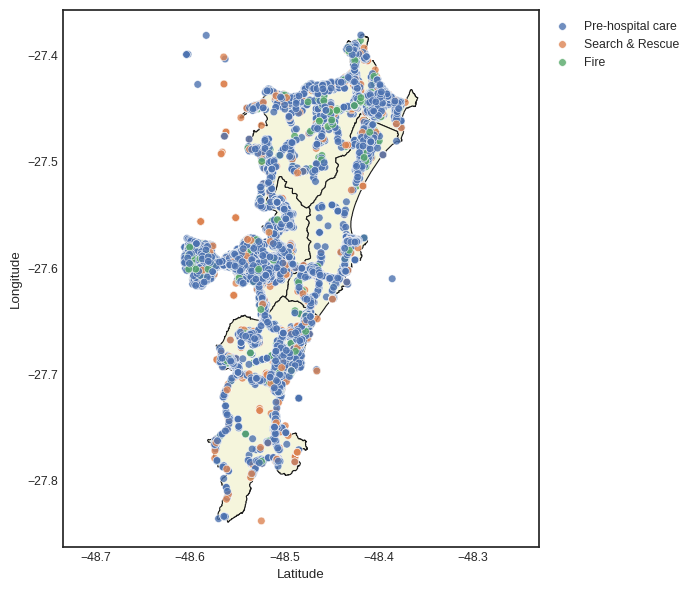

In [9]:
main_occur_types = [ 'Search & Rescue', 'Pre-hospital care', 'Fire']

data_main_types = data.loc[data['OccurrenceType'].isin(main_occur_types)]

# Plot the GeoDataFrame on the map

fig, base = plt.subplots(figsize=(11, 6))
base.set_aspect('equal')

# plot do mapa
shape_data.plot(ax=base, color='beige', edgecolor='k', zorder=1)

base = adjust_limits(base)
xlim, ylim = base.get_xlim(), base.get_ylim()

# overlay das ocorrencias sobre o mapa
sns.scatterplot(x="lat_ocorrencia", y="lon_ocorrencia", marker='o', s = 30, alpha = 0.8, ax=base, hue='OccurrenceType', data=data_main_types)

base.set_xlim(xlim)
base.set_ylim(ylim)

# Increase the size of labels and axes
plt.xlabel('Latitude')
plt.ylabel('Longitude')
#plt.title('Mapa de Ocorrências em Florianópolis', fontsize=16)
plt.legend(bbox_to_anchor=(1, 1), loc="upper left", frameon=False)  # Add title to the legend

# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()

In [10]:

Xhosp = data.loc[data['TipoOcorrênciaEncerramento'] == 'ATENDIMENTO PRÉ-HOSPITALAR']
Xfire = data.loc[data['TipoOcorrênciaEncerramento'] == 'INCÊNDIO']

ds_list = [Xhosp, Xfire]
names = ["DS-ambulance", "DS-fire"]

for i,X in enumerate(ds_list):
    print(f"Cleaning data set: {names[i]}")
    num_samples = len(X)
    print(f"Number of samples of type 'atendimento pré-hospitalar': {num_samples}")


    X = X.loc[X["lat_ocorrencia"] >= -48.61,:]
    num_samples = len(X)
    print(f"Number of samples after geographical outliers: {num_samples}")



    X["Date"] = pd.to_datetime(X["Data/Hora"], infer_datetime_format=True).dt.floor('1D')

    # Count the number of missing values in 'lat_ocorrencia' and 'lon_ocorrencia' columns
    missing_lat = X['lat_ocorrencia'].isna().sum()
    missing_lon = X['lon_ocorrencia'].isna().sum()

    print("Number of missing values in 'lat_ocorrencia':", missing_lat)
    print("Number of missing values in 'lon_ocorrencia':", missing_lon)

    ds_list[i] = X.copy(deep = True)

Xhosp, Xfire = ds_list

Cleaning data set: DS-ambulance
Number of samples of type 'atendimento pré-hospitalar': 24748
Number of samples after geographical outliers: 24748
Number of missing values in 'lat_ocorrencia': 0
Number of missing values in 'lon_ocorrencia': 0
Cleaning data set: DS-fire
Number of samples of type 'atendimento pré-hospitalar': 2561
Number of samples after geographical outliers: 2561
Number of missing values in 'lat_ocorrencia': 0
Number of missing values in 'lon_ocorrencia': 0


# Spatial Segmentation

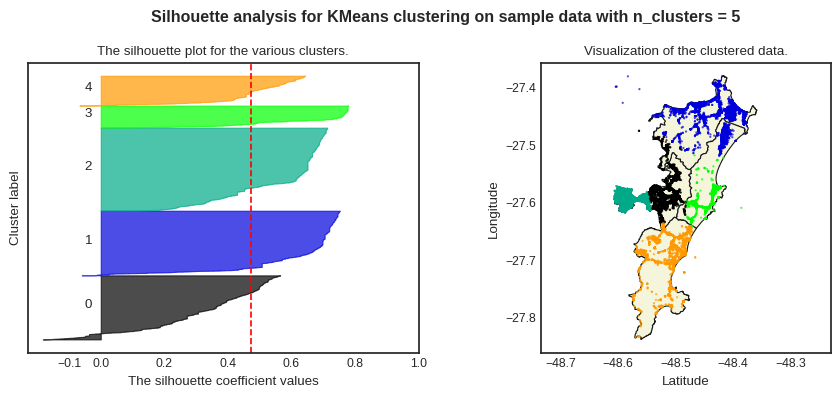

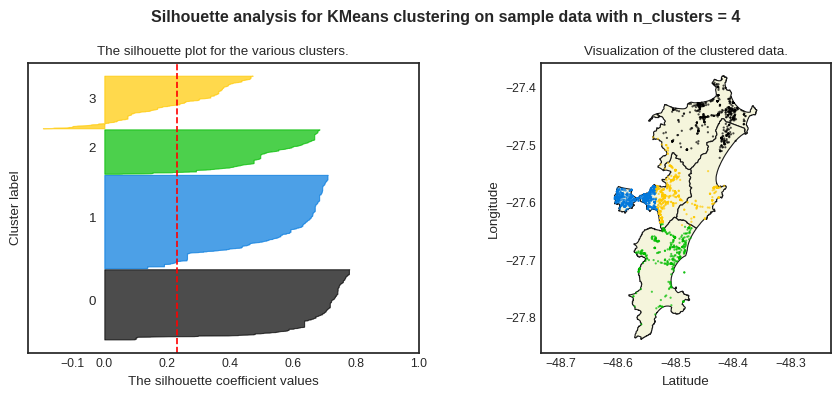

Best k and silhouette for DS-ambulance: (5, 0.5175423527843772)
Best k and silhouette for DS-fire: (4, 0.5140741948965386)


In [11]:
Xhosp_seg, min_silhouette_hosp = spatial_segment(Xhosp, max_clusters = 5, shape_data = shape_data)
Xfire_seg, min_silhouette_fire = spatial_segment(Xfire, max_clusters = 5, shape_data = shape_data)

print(f'Best k and silhouette for DS-ambulance: {Xhosp_seg.shape[1], min_silhouette_hosp}')
print(f'Best k and silhouette for DS-fire: {Xfire_seg.shape[1], min_silhouette_fire}')


# More cleaning on the segmented data

## DS-ambulance

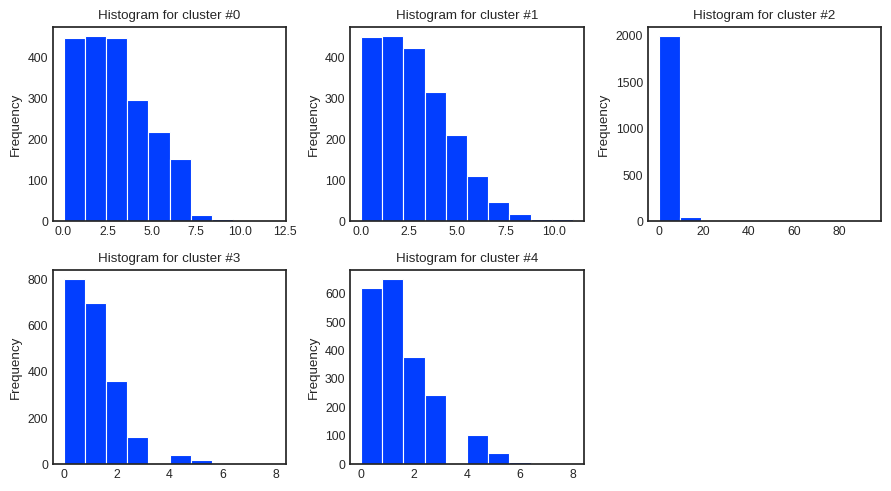

In [12]:
plot_cluster_histograms(Xhosp_seg)


In [13]:
print(Xhosp_seg.max(axis = 0))

cluster_label
0    12
1    11
2    94
3     8
4     8
dtype: int64


In [14]:
# prompt: Find dates where Xseg[2] > 20 and also show the values of each date

dates_with_high_cluster_2 = Xhosp_seg[2][Xhosp_seg[2] > 20].index.tolist()
values_for_high_cluster_2 = Xhosp_seg[2][Xhosp_seg[2] > 20].values.tolist()

for i, date in enumerate(dates_with_high_cluster_2):
  print(f"Date: {date}, Value: {values_for_high_cluster_2[i]}")


Date: 2018-01-20 00:00:00, Value: 32
Date: 2018-02-28 00:00:00, Value: 94


In [15]:
# prompt: get values of Xseg[2] three days before and three days after 2018-02-28

date_index = Xhosp_seg[2].index.get_loc("2018-02-28")

start_date = Xhosp_seg[2].index[date_index - 3]
end_date = Xhosp_seg[2].index[date_index + 3]

values_around_date = Xhosp_seg[2][start_date:end_date]

print(values_around_date)


Date
2018-02-25     6
2018-02-26     5
2018-02-27     4
2018-02-28    94
2018-03-01     6
2018-03-02     4
2018-03-03     2
Name: 2, dtype: int64


In [16]:
# prompt: replace the largest value of Xseg[2] with its second largest value

max_value = Xhosp_seg[2].max()
mean_value = int(Xhosp_seg[2].mean())

Xhosp_seg[2] = Xhosp_seg[2].replace(max_value, mean_value)


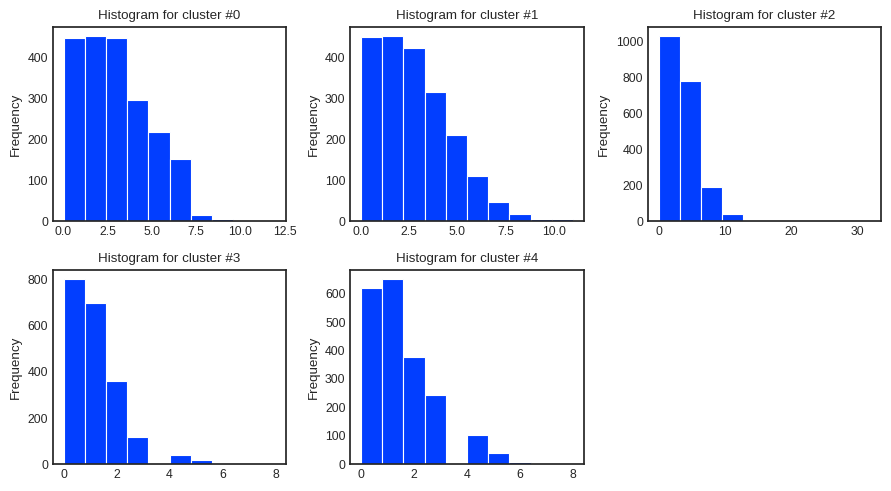

In [17]:
plot_cluster_histograms(Xhosp_seg)

## DS-fire

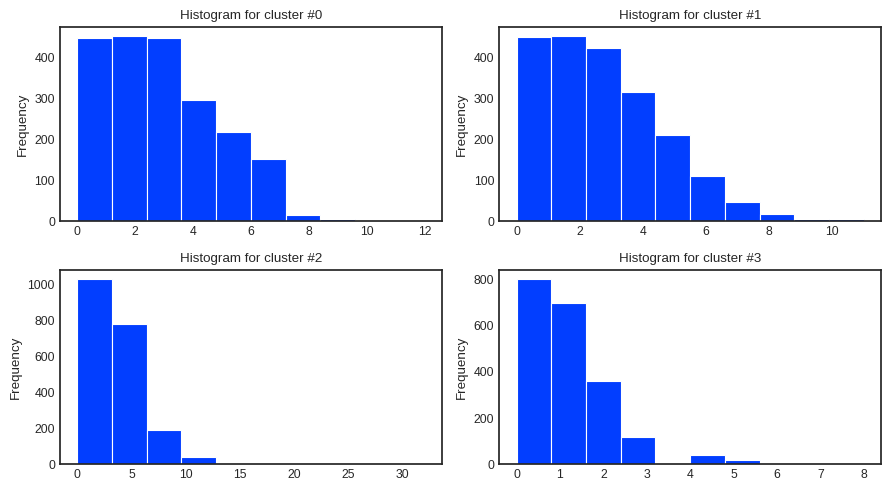

In [18]:
# prompt: plot histogram of each column of Xseg in a 2x2 plot

plot_cluster_histograms(Xfire_seg)

## Saving the cleaned and segmented data



In [19]:
Xhosp_seg.to_csv("data_ambulance_seg.csv")
Xfire_seg.to_csv("data_track_seg.csv")


# Overall data analysis


## DS-ambulance/DS-fire

In [20]:
Xseg = Xhosp_seg


(2037,)


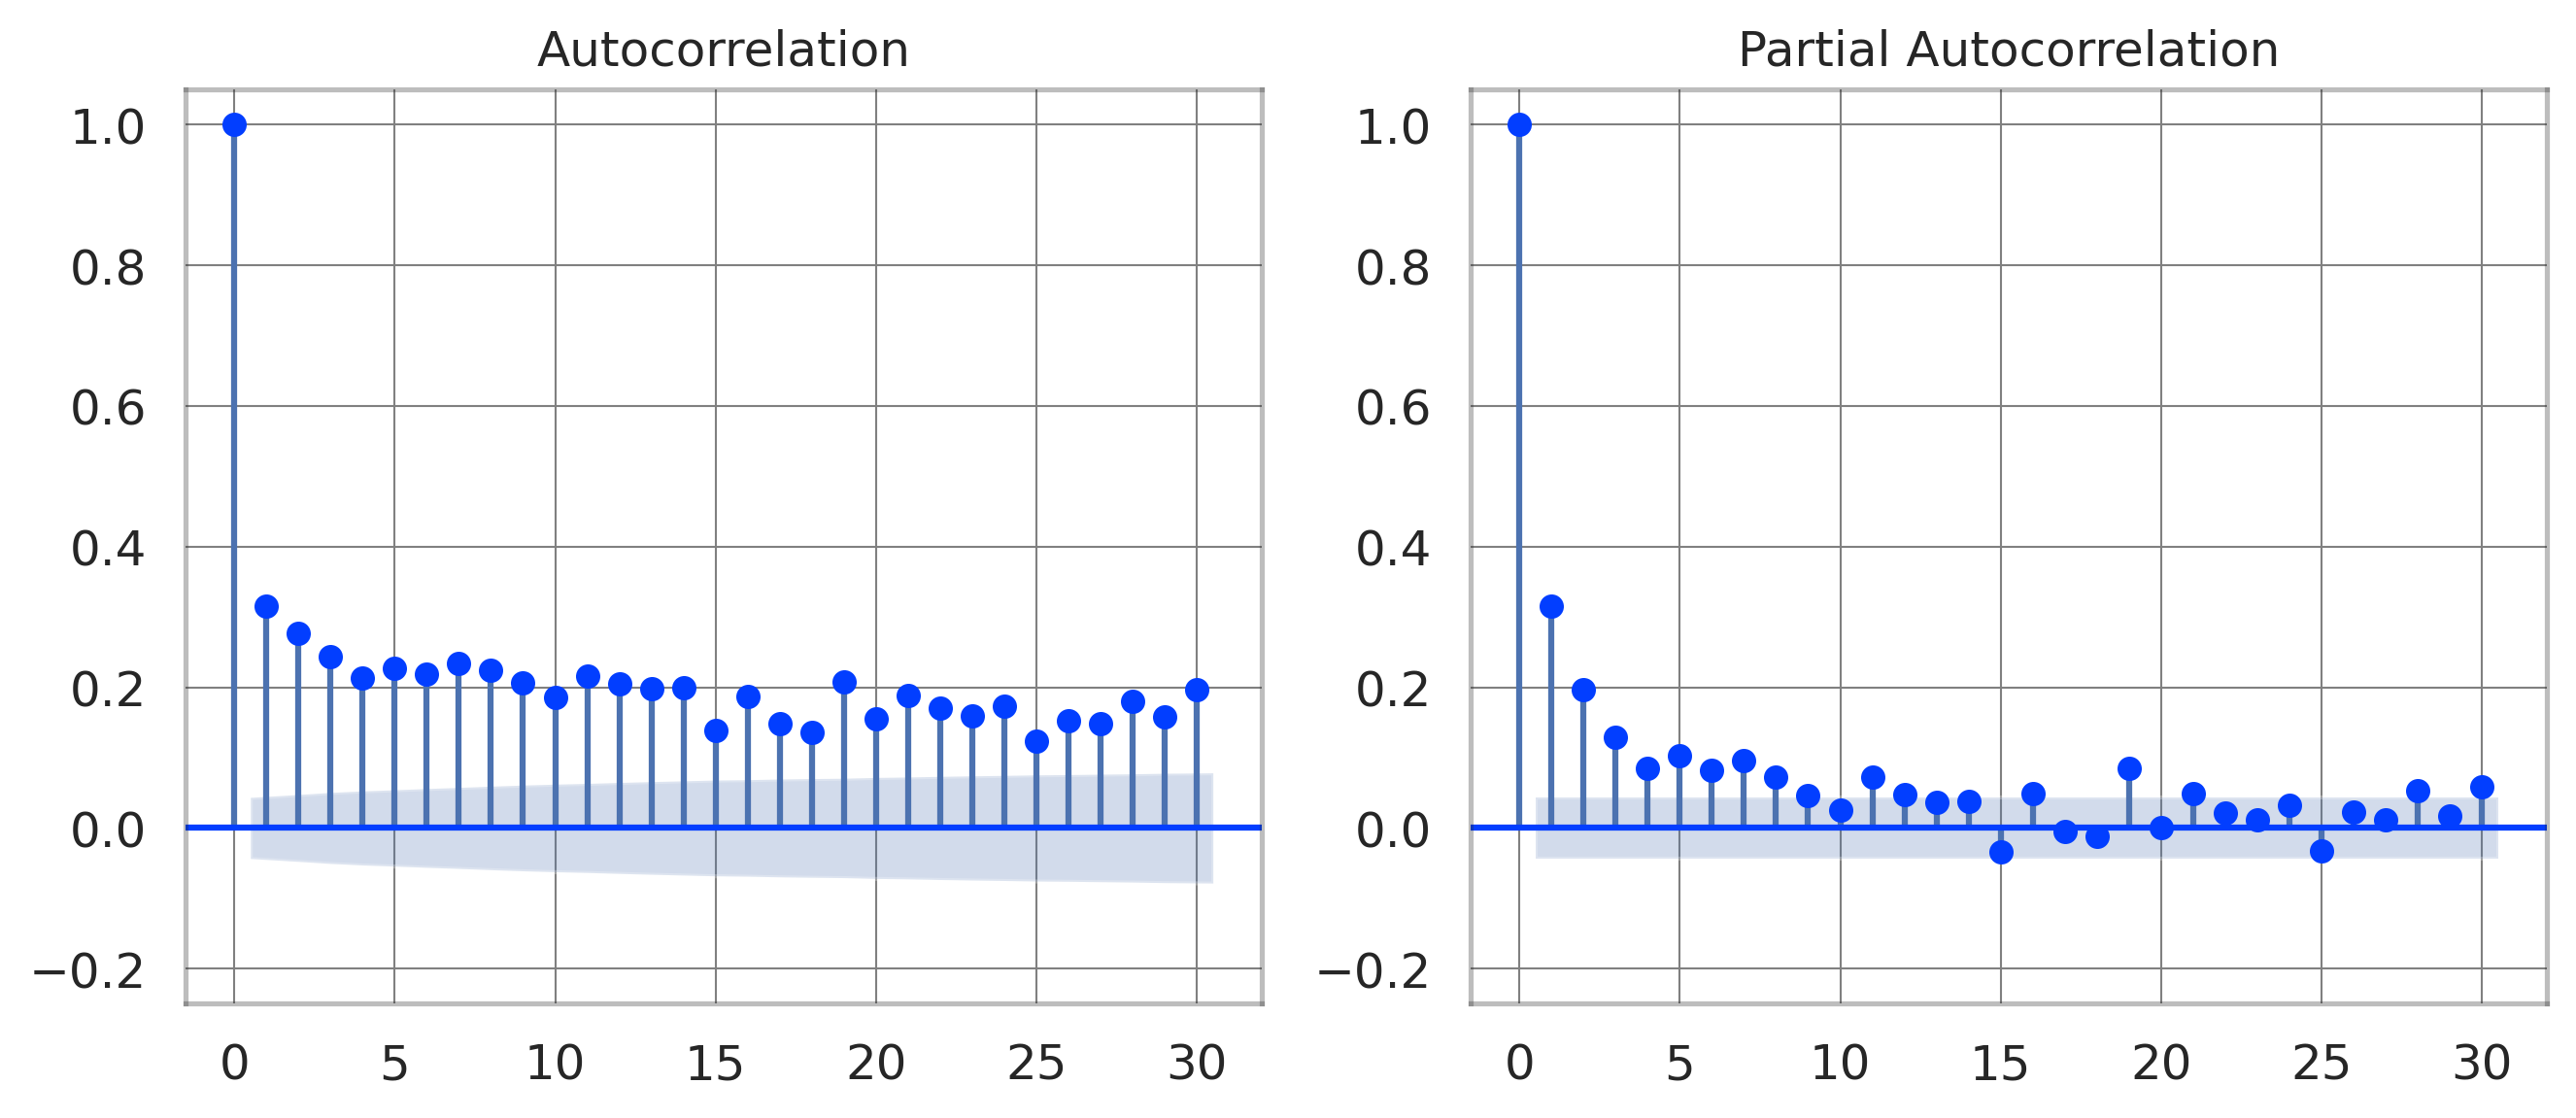

In [21]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()


sns.set_style(style='white')

# Xall contains all clusters (segments) combined
Xall = Xseg.sum(axis=1)
print(Xall.shape)
# Draw Plot
fig, (ax1, ax2) = plt.subplots(1, 2, dpi= 300)
plot_acf(Xall.tolist(), ax=ax1, lags=30, color = color_list[0])
plot_pacf(Xall.tolist(), ax=ax2, lags=30, color = color_list[0])

# https://towardsdatascience.com/time-series-from-scratch-autocorrelation-and-partial-autocorrelation-explained-1dd641e3076f
# lighten the borders
ax1.spines["top"].set_alpha(.3); ax2.spines["top"].set_alpha(.3)
ax1.spines["bottom"].set_alpha(.3); ax2.spines["bottom"].set_alpha(.3)
ax1.spines["right"].set_alpha(.3); ax2.spines["right"].set_alpha(.3)
ax1.spines["left"].set_alpha(.3); ax2.spines["left"].set_alpha(.3)
ax1.set_title('Autocorrelation')
ax2.set_title('Partial Autocorrelation')


ax1.grid(which="major", color="grey", linestyle="-", linewidth=0.5)
ax2.grid(which="major", color="grey", linestyle="-", linewidth=0.5)

ax1.set_ylim(-0.25,1.05)
ax2.set_ylim(-0.25,1.05)

# font size of tick labels
ax1.tick_params(axis='both', labelsize=12)
ax2.tick_params(axis='both', labelsize=12)
plt.tight_layout()
plt.show()


In [22]:
# prompt: create sub dataframe from Xall of all days with Year = Y and month = M. Check if each date is in Xall before filtering. Also check for leap years when it's February (M = 2)

import pandas as pd


# Example usage
base_year = 2018
base_month = 1
Xall_1month = sub_dataframe_by_month(Xall, base_year, base_month, base_year, base_month)
if base_month + 11 > 12:
    end_year = base_year + 1
    end_month = (base_month + 11) % 12
else:
    end_year = base_year
    end_month = base_month + 11

Xall_1year = sub_dataframe_by_month(Xall, base_year, base_month, end_year, end_month)

Xall_monthly = Xall.resample('M').sum()
Xall_1year_weekly = Xall_1year.resample('W').sum()

print(Xall_1month.shape)
print(Xall_1year.shape)
print(Xall_1year_weekly.shape)
print(Xall_monthly.shape)



(31,)
(365,)
(53,)
(67,)


In [23]:
# prompt: get month acronym (3 letters) based on integer

month_acronyms = {
    1: "Jan",
    2: "Feb",
    3: "Mar",
    4: "Apr",
    5: "May",
    6: "Jun",
    7: "Jul",
    8: "Aug",
    9: "Sep",
    10: "Oct",
    11: "Nov",
    12: "Dec",
}

base_month_acronym = month_acronyms[base_month]
end_month_acronym = month_acronyms[end_month]


In [24]:
from statsmodels.tsa.seasonal import seasonal_decompose

result1month = seasonal_decompose(Xall_1month, period=7, model='additive')
result1year = seasonal_decompose(Xall_1year_weekly, period=4, model='additive')
result_all = seasonal_decompose(Xall_monthly, period=12, model='additive')


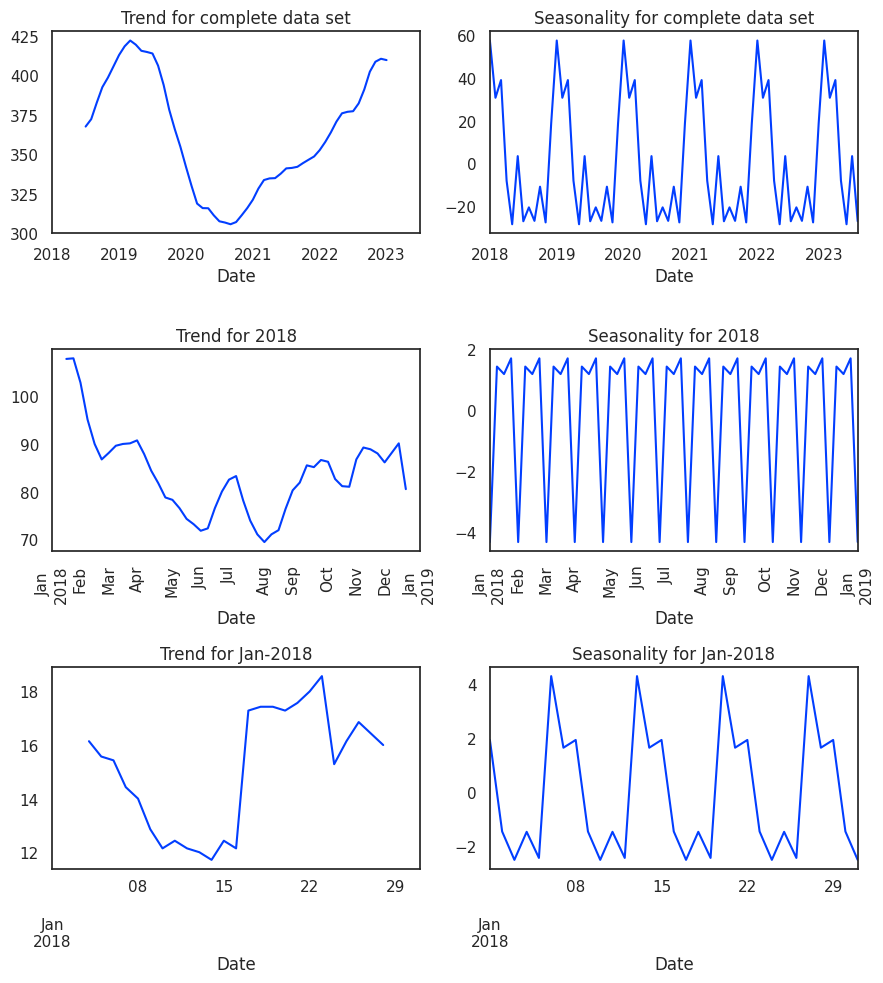

In [25]:
# prompt: seasonal decompose data1month and data1year

import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Plot the decomposed components for data1month
fig, axs = plt.subplots(3, 2, figsize = (9, 10))

# Plot the trend component
result_all.trend.plot(ax=axs[0][0], label='Trend', color = color_list[0])
axs[0][0].set_title('Trend for complete data set')

# Plot the seasonal component
result_all.seasonal.plot(ax=axs[0][1], label='Season', color = color_list[0])
axs[0][1].set_title('Seasonality for complete data set')

# Plot the residual component
result1year.trend.plot(ax=axs[1][0], label='Trend', color = color_list[0])
axs[1][0].set_title(f'Trend for {base_year}')


# Plot the residual component
result1year.seasonal.plot(ax=axs[1][1], label='Season', color = color_list[0])
axs[1][1].set_title(f'Seasonality for {base_year}')



# Plot the residual component
result1month.trend.plot(ax=axs[2][0], label='Trend', color = color_list[0])
axs[2][0].set_title(f'Trend for {base_month_acronym}-{base_year}')


# Plot the residual component
result1month.seasonal.plot(ax=axs[2][1], label='Season', color = color_list[0])
axs[2][1].set_title(f'Seasonality for {base_month_acronym}-{base_year}')



axs[1,0].set_xticklabels(axs[1,0].get_xticklabels(), rotation=90);
axs[1,1].set_xticklabels(axs[1,1].get_xticklabels(), rotation=90);


plt.tight_layout()
plt.savefig('tsa_year_month.png', dpi = 300)


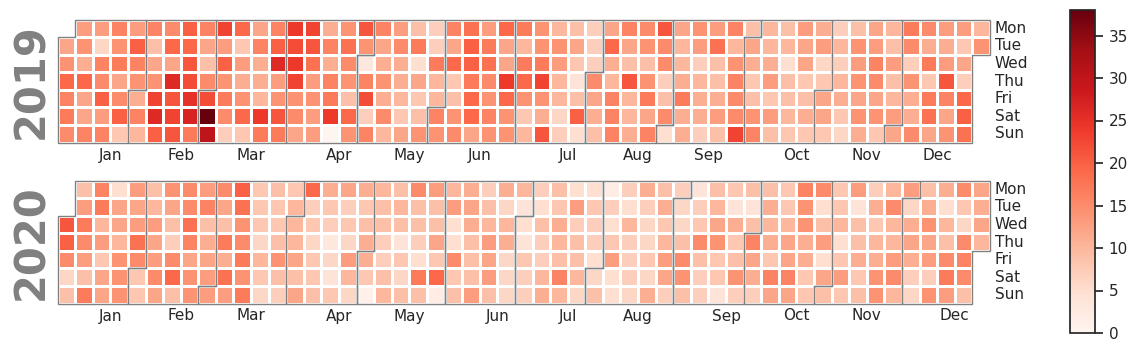

In [26]:
# prompt: plot a calplot of Xall for years 2019, 2020 and 2022

import matplotlib.pyplot as plt
import calplot

calplot.calplot(Xall['2019':'2020'], cmap = 'Reds', colorbar=True, yearlabel_kws={'fontname':'sans-serif'})
plt.show()


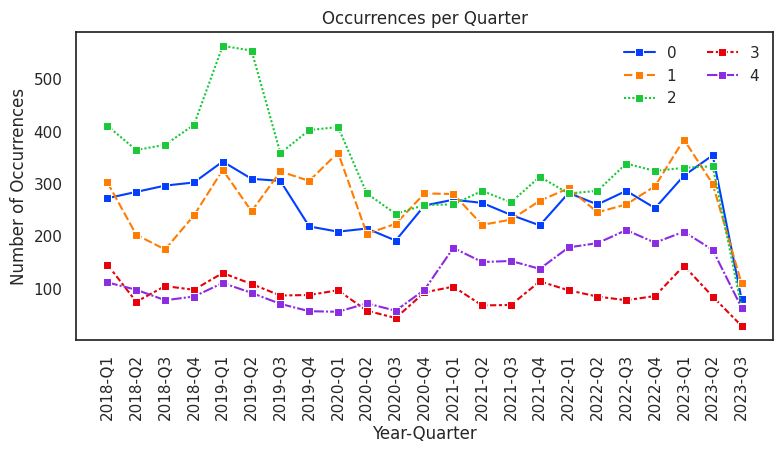

In [27]:
# prompt: plot the occurences per quarter of each column in Xhosp_seg. Format the X axis to show Year-Quarter i the tick labels (ex: 2023-Q1)

import matplotlib.pyplot as plt
import pandas as pd

Xseg_ = Xseg.copy()
# Create a new dataframe with the year and quarter for each date
Xseg_['Year'] = pd.DatetimeIndex(Xseg_.index).year
Xseg_['Quarter'] = pd.DatetimeIndex(Xseg_.index).quarter

# Group the data by year and quarter
Xseg_ = Xseg_.groupby(['Year', 'Quarter']).sum()

# Create a new dataframe with the year-quarter as the index
Xseg_ = Xseg_.reset_index()

# Convert the year and quarter to a string in the format 'Year-QQuarter'
Xseg_['Year-Quarter'] = Xseg_['Year'].astype(str) + '-Q' + Xseg_['Quarter'].astype(str)

# Set the 'Year-Quarter' column as the index
Xseg_ = Xseg_.set_index('Year-Quarter')

# Plot the data
#Xseg_[Xseg.columns].plot.bar()
sns.lineplot(Xseg_[Xseg.columns], palette = 'bright', marker = 's')

# Format the x-axis tick labels
plt.legend(ncols = 2)
plt.xticks(rotation=90)
plt.xlabel('Year-Quarter')
plt.ylabel('Number of Occurrences')
plt.title('Occurrences per Quarter')
plt.show()
